In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt #Open Korea Text
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

#먼저 데이터가 잘 읽어졌는지 확인한다.
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head() #데이터의 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 감성분석을 하기 위해..  
먼저 데이터를 받고, 전처리를 하는 과정을 거쳐야 한다.

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
#stopword는 각 조사로, 의미를 가지지는 않으나 단어별로 구분하는 기준으로 적절하다

def load_data(train_data, test_data, num_words=10000):#load data - raw한 텍스트 파일을 처리할 수 있게 끔 정제, 필요한 데이터를 불러온다
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 가지고 있는 단어나 stopword에 포함되어있지 않으면
                                                                    #제거해준다 !
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
nsmc = load_data(train_data, test_data)


In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
#print(get_encoded_sentence(X_train[0], index_to_word))
#print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

## 데이터셋 분포 확인  

이제 데이터셋의 문장의 길이를 pad_sequences를 통해 통일해 줘야한다.  
이 때 문장 최대 길이 maxlen의 값이 전체 모델 성능에 영향을 미치게 되는데, 이에 맞는 적절한 값을 찾기 위해서는  
전체 데이터셋의 분포를 확인하는 것이 도움이 된다.

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


##  pad_sequences  
분포를 확인했으니, 이제 PAD를 통해 문장 전체의 길이를 통일해 줘야한다.

In [7]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [8]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## pre? &nbsp;  post?  
padding 방식은 pre와 post가 있다. 이는 PAD를 문장의 앞쪽과 뒤쪽 어느쪽에 할 것인지의 의미를 갖는데,  
RNN을 활용할 때에는 순차적으로 처리되는 입력데이터 때문에, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이  
미치게 된다. 따라서 영향을 가장 많이 미치는 마지막 입력이 의미를 가지고 있지 않은 PAD로 채워지는 것은 아주  
비효율적인 것이다.


# 모델 정의 및 학습 ! 

## validation set 분리  
전 Toy project에서는 validation을 쓴 적이없다. Linear Classifier에서는 validation을 쓰기에 적절하지 못한 수의 데이터를 가지기 때문에 잘  
사용하지 않았지만, 이번 데이터에서는 validation set을 만들어 더 정확한 학습을 시켰다.  

### Validation ?  
 validation은 가지고있는 train set중에서 일부를 validation set으로 지정하여 test 전에 validation 하는 것을 의미한다.  
 이러한 데이터셋을 가지고 있을 때의 플로우는 <strong>학습 - validation set을 통한 검증 - 테스트</strong>로 이루어지며, 이는 마치 고등학생이  
 공부를하고, 모의고사를 본 뒤에 수능을 보는 것과 같다고 생각하면 될 것이다. 

In [9]:
# validation set 10000건 분리
x_val = x_train[:250]   
y_val = y_train[:250]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[250:]  
partial_y_train = y_train[250:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(145932, 41)
(145932,)


데이터들을 분리 했으니 이제 모델을 구성하고 학습시킬 차례다 !

## RNN

In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(8))#RNN에서의 대표적인 layer이다.
model_RNN.add(keras.layers.Dense(8, activation='relu'))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid')) 
model = model_RNN

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
286/286 [==============================] - 2s 6ms/step - loss: 0.5841 - accuracy: 0.6477 - val_loss: 0.4076 - val_accuracy: 0.8240
Epoch 2/5
286/286 [==============================] - 1s 5ms/step - loss: 0.3495 - accuracy: 0.8527 - val_loss: 0.3665 - val_accuracy: 0.8320
Epoch 3/5
286/286 [==============================] - 1s 5ms/step - loss: 0.3221 - accuracy: 0.8651 - val_loss: 0.3885 - val_accuracy: 0.8040
Epoch 4/5
286/286 [==============================] - 1s 5ms/step - loss: 0.3126 - accuracy: 0.8688 - val_loss: 0.3421 - val_accuracy: 0.8480
Epoch 5/5
286/286 [==============================] - 1s 5ms/step - loss: 0.3016 - accuracy: 0.8746 - val_loss: 0.3661 - val_accuracy: 0.8320


In [12]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)


1537/1537 - 2s - loss: 0.3680 - accuracy: 0.8403
[0.36800286173820496, 0.8403075933456421]


RNN에서는 epoch 10 기준 , 정확도는 총 0.83이 나왔다.  

이를 좀 더 직관적으로 확인하기 위해 그래프로 그려보았다

In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그린다

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


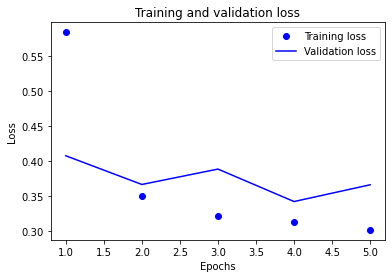

In [14]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs') #x축은 Epoch
plt.ylabel('Loss') #y축은 loss 값
plt.legend()

plt.show()

Epoch에 따른 loss 값에 대한 그래프이다. 반대로 Epoch에 따른 Accuracy를 확인한다.

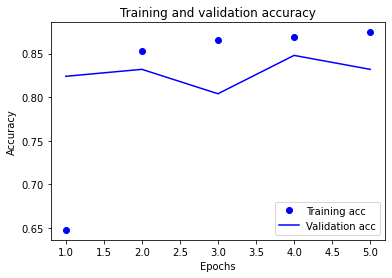

In [15]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs') #x축은 Epoch
plt.ylabel('Accuracy')#y축은 Accuracy
plt.legend()

plt.show()

## 1-D Convolution Neural Network(1-D CNN)

In [16]:
vocab_size = 10000  
word_vector_dim = 16   

model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model = model_CNN
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
286/286 [==============================] - 9s 32ms/step - loss: 0.4736 - accuracy: 0.7645 - val_loss: 0.3709 - val_accuracy: 0.8440
Epoch 2/5
286/286 [==============================] - 1s 4ms/step - loss: 0.3330 - accuracy: 0.8592 - val_loss: 0.3688 - val_accuracy: 0.8400
Epoch 3/5
286/286 [==============================] - 1s 4ms/step - loss: 0.3029 - accuracy: 0.8737 - val_loss: 0.3660 - val_accuracy: 0.8480
Epoch 4/5
286/286 [==============================] - 1s 4ms/step - loss: 0.2787 - accuracy: 0.8851 - val_loss: 0.3668 - val_accuracy: 0.8360
Epoch 5/5
286/286 [==============================] - 1s 4ms/step - loss: 0.2527 - accuracy: 0.8983 - val_loss: 0.3745 - val_accuracy: 0.8360


In [18]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3545 - accuracy: 0.8508
[0.3545270562171936, 0.8508045673370361]


In [19]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


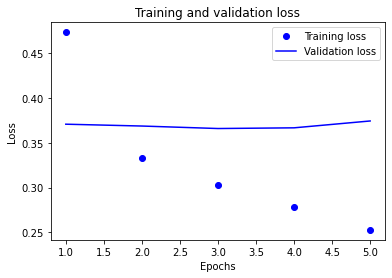

In [20]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

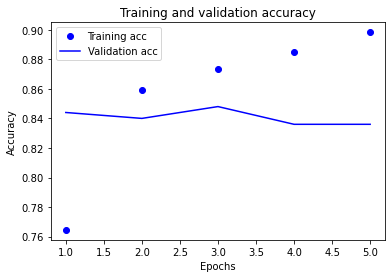

In [21]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Global Max Pooling 1D

In [22]:
vocab_size = 10000  
word_vector_dim = 16   

model_GMP = keras.Sequential()
model_GMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP.add(keras.layers.GlobalMaxPooling1D())
model_GMP.add(keras.layers.Dense(8, activation='relu'))
model_GMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model = model_GMP
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
286/286 [==============================] - 1s 3ms/step - loss: 0.5915 - accuracy: 0.7315 - val_loss: 0.4273 - val_accuracy: 0.8400
Epoch 2/5
286/286 [==============================] - 1s 3ms/step - loss: 0.3846 - accuracy: 0.8414 - val_loss: 0.3464 - val_accuracy: 0.8400
Epoch 3/5
286/286 [==============================] - 1s 3ms/step - loss: 0.3264 - accuracy: 0.8624 - val_loss: 0.3482 - val_accuracy: 0.8440
Epoch 4/5
286/286 [==============================] - 1s 3ms/step - loss: 0.2992 - accuracy: 0.8755 - val_loss: 0.3527 - val_accuracy: 0.8440
Epoch 5/5
286/286 [==============================] - 1s 3ms/step - loss: 0.2802 - accuracy: 0.8850 - val_loss: 0.3621 - val_accuracy: 0.8440


In [24]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.3631 - accuracy: 0.8449
[0.3630823791027069, 0.8449050784111023]


Global Max Pooling은 가장 낮은 0.827이 나왔다.

In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


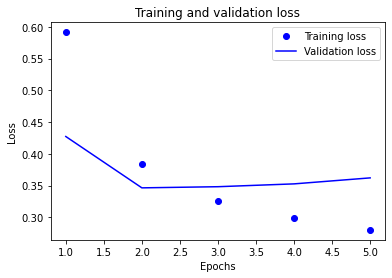

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

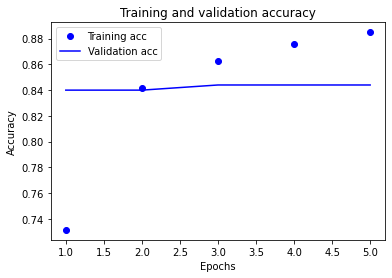

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 부족한 Accuracy..  
0.85가 나오긴했지만, 대부분이 0.84에 그치는 경우가 많았다. 이를 해결하기 위해서는 '워드 임베딩'이라는 기법을 사용할 수 있다.

### Word2Vec &nbsp;..? &nbsp; Word Embedding ! 
자연어는 무수히 많은 자음, 모음, 음절, 어절 등으로 구성되어있다. 그에 따라서 라벨링 비용이 많이 들게 되어있는데,  
이를 위해 단어의 특성을 저차원의 벡터값으로 표현할 수 있는 gensim을 이용한 word embedding 기법을 사용해준다면 좋을 것이다.  

### Embedding Layer
이 레이어는 <strong>우리가 가진 사전의 단어 개수 x 워드 벡터 사이즈</strong> 만큼의 크기를 가진 학습 파라미터이다. <span style ="color : red">gensim을 이용한 word embedding기법과는 다르다 !</span>
  
일단은.. 워드벡터를 다루는데 유용한 gensim을 사용해야한다.

In [28]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [38]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
f = open(word2vec_file_path, 'w',encoding='utf-8')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다.
 #단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록한다.
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

미리 학습된 ko.bin을 사용했다!  

아래는 단어 '영화'를 벡터화 한것이다.

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.19715878, -0.23254074, -0.19156928, -0.20823441, -0.20563354,
       -0.20369603, -0.21473718, -0.18940356, -0.19591758, -0.21688095,
       -0.02800738, -0.11971339, -0.07579377, -0.22632268, -0.10024515,
       -0.20568493], dtype=float32)

In [40]:
word_vectors.similar_by_word("영화")#파라미터와 비슷한 단어를 보여준다!

[('을', 0.9949984550476074),
 ('만드', 0.9909788370132446),
 ('다', 0.9896421432495117),
 ('긴장감', 0.9878560900688171),
 ('묘사', 0.9867969751358032),
 ('하', 0.9804726839065552),
 ('고', 0.9801724553108215),
 ('음', 0.9797558188438416),
 ('중', 0.9792364239692688),
 ('마구', 0.9782804250717163)]

In [41]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]


In [42]:
model = model_RNN#RNN모델 이용
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
286/286 [==============================] - 2s 6ms/step - loss: 0.2533 - accuracy: 0.8931 - val_loss: 0.4062 - val_accuracy: 0.8520
Epoch 2/5
286/286 [==============================] - 1s 5ms/step - loss: 0.2437 - accuracy: 0.8984 - val_loss: 0.4191 - val_accuracy: 0.8280
Epoch 3/5
286/286 [==============================] - 1s 5ms/step - loss: 0.2376 - accuracy: 0.9009 - val_loss: 0.4066 - val_accuracy: 0.8400
Epoch 4/5
286/286 [==============================] - 1s 5ms/step - loss: 0.2312 - accuracy: 0.9040 - val_loss: 0.4253 - val_accuracy: 0.8200
Epoch 5/5
286/286 [==============================] - 1s 5ms/step - loss: 0.2237 - accuracy: 0.9077 - val_loss: 0.4378 - val_accuracy: 0.8320


In [44]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3944 - accuracy: 0.8431
[0.39436790347099304, 0.8430538773536682]


In [45]:
model = model_CNN #CNN 모델을 이용
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/5
286/286 [==============================] - 1s 4ms/step - loss: 0.1130 - accuracy: 0.9607 - val_loss: 0.6275 - val_accuracy: 0.8320
Epoch 2/5
286/286 [==============================] - 1s 4ms/step - loss: 0.0952 - accuracy: 0.9677 - val_loss: 0.6833 - val_accuracy: 0.8320
Epoch 3/5
286/286 [==============================] - 1s 4ms/step - loss: 0.0845 - accuracy: 0.9722 - val_loss: 0.7137 - val_accuracy: 0.8240
Epoch 4/5
286/286 [==============================] - 1s 4ms/step - loss: 0.0786 - accuracy: 0.9744 - val_loss: 0.7654 - val_accuracy: 0.8360
Epoch 5/5
286/286 [==============================] - 1s 4ms/step - loss: 0.0687 - accuracy: 0.9787 - val_loss: 0.8162 - val_accuracy: 0.8200
1537/1537 - 2s - loss: 0.7420 - accuracy: 0.8220
[0.7419681549072266, 0.8219988942146301]


In [46]:
model = model_GMP# global max pool 모델을 이용
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/5
286/286 [==============================] - 1s 4ms/step - loss: 0.2203 - accuracy: 0.9140 - val_loss: 0.4206 - val_accuracy: 0.8200
Epoch 2/5
286/286 [==============================] - 1s 4ms/step - loss: 0.2130 - accuracy: 0.9172 - val_loss: 0.4291 - val_accuracy: 0.8280
Epoch 3/5
286/286 [==============================] - 1s 3ms/step - loss: 0.2060 - accuracy: 0.9208 - val_loss: 0.4358 - val_accuracy: 0.8200
Epoch 4/5
286/286 [==============================] - 1s 3ms/step - loss: 0.1994 - accuracy: 0.9239 - val_loss: 0.4512 - val_accuracy: 0.8280
Epoch 5/5
286/286 [==============================] - 1s 3ms/step - loss: 0.1930 - accuracy: 0.9269 - val_loss: 0.4698 - val_accuracy: 0.8200
1537/1537 - 1s - loss: 0.4460 - accuracy: 0.8345
[0.44598326086997986, 0.8345301747322083]


## 마치며.. 

생각보다 너무 복잡했다.. validation set의 수를 변경하고 epochs를 변경해도 accuracy는  
쉽게 오르지 않았고, 특히 word embedding을 정확히 사용하지 못했는지 기대했던 값보다 오히려 더 낮은 Accuracy를 보였고 두 파라미터들을 수정해서 어떻게 맞출 수는 있겠다 라는 생각이 들었지만 정상적인 모델이라는 생각은 들지 않았기 때문에 더이상 진행하지 않았다.  
word embedding에 관해서는 도중에 embedded layer와 혼동이 있어서 꽤 많은 시간을 투자하게 됐고, 관련 함수에 대해서도 